In [23]:
! pip install mne_connectivity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import packages

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import os, requests

from sklearn.decomposition import PCA
# import torch

import mne_connectivity as mnec

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
# data retrieval

fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)
                
alldat = np.load(fname, allow_pickle=True)['dat']

In [ ]:
def get_subject_data(subject = 0, im_vs_real = 0, vector = True):
    """
    Get brain activity data from subject performing imagery or real movement
    
    Args:
    - subject: number of subject (0-6)
    - im_vs_real: 0 real, 1 imaginary
    
    Returns:
    - samples: 2-dim. numpy array (trials for each channel x time) 
        with voltage time series in uV
    - labels: 2-dim. numpy array (trials for each channel x 2) 
        with number of brodman area and movement type for each sample
    """
    
    data = alldat[subject][im_vs_real]
    
    trange = np.arange(0, 3000)
    V = data['V'].astype('float32')
    scale_uv = data['scale_uv'].astype('float32')

    number_of_trials = 60 # len(data['t_on']) = 60 for all cases
    number_of_channels = len(data['locs'])

    trial_indices = (data['t_on'][:, np.newaxis] + trange).flatten() 
    
    labels = np.zeros((number_of_trials, number_of_channels, 2)) # trials for each electrode location x 2, 
                                                                 # with brodmann area & movement type as columns
    samples = np.zeros((number_of_trials, number_of_channels, 3000)) # trials for each electrode location x time

    movement_types = data['stim_id']
    labels[:,:,1] = np.tile(movement_types, (number_of_channels, 1)).T

    # iterate through all channels with this loop
    for ch_num in range(number_of_channels):

        number_of_brodmann_area = int(data['Brodmann_Area'][ch_num][14:])
        labels[:, ch_num,  0] = np.full(number_of_trials, number_of_brodmann_area)
        
        V_in_uv = V[:, ch_num] * scale_uv[ch_num]
        samples[:, ch_num, :] = V_in_uv[trial_indices].reshape((number_of_trials, 3000))

    # choose time series vectors for PCA
    if vector == True:
        labels = labels.reshape((number_of_trials * number_of_channels, 2))
        samples = samples.reshape((number_of_trials * number_of_channels, 3000))
    
    return(samples, labels)

def correlate_matrices(corr1, corr2):
    """Correlate off-diagonal elements of two 2-dim matrices

    Args:
        corr1 (np.ndarray): S x S correlation coefficient matrix
        corr2 (np.ndarray): S x S correlation coefficient matrix to correlate with corr1

    Returns:
        float: correlation coefficient between the off-diagonal elements
              of corr1 and corr2

    """

    # Extract off-diagonal elements of each RDM
    ioffdiag = np.tril_indices(corr1.shape[0], k=1)  # indices of off-diagonal elements
    corr1_offdiag = corr1[ioffdiag]
    corr2_offdiag = corr2[ioffdiag]

    # compute correlation coefficient 
    corr_coef = np.corrcoef(corr1_offdiag, corr2_offdiag)[0,1]

    return corr_coef

def diff_measure(corr_coeff):
    # compute a measure of dissimilarity from correlation 
    return((1 - corr_coeff) / 2)

In [32]:
def cross_coherence(freq_band = [30, 100], random = False, corr_degree = 0):
    """...
    
    args:
      
    """

    corrs = [] 
    # diffs_stds = [] # for error propagation
    
    for subject in range(7):
        
        if random == False: 
            X_re, y_re = get_subject_data(subject, im_vs_real = 0, vector = False)
            X_im, y_im = get_subject_data(subject, im_vs_real = 1, vector = False)
        else:
            X_re, X_im = get_random_data(corr_degree)
        

        coh_re = mnec.spectral_connectivity_epochs(X_re, fmin = freq_band[0], fmax = freq_band[1], method='coh', sfreq=1000, mode='fourier', faverage=True)
        coh_im = mnec.spectral_connectivity_epochs(X_im, fmin = freq_band[0], fmax = freq_band[1], method='coh', sfreq=1000, mode='fourier', faverage=True)

        number_of_channels = X_re.shape[1]
        coh_mat_re = coh_re.get_data().reshape((number_of_channels, number_of_channels))
        coh_mat_im = coh_im.get_data().reshape((number_of_channels, number_of_channels))

        corr = correlate_matrices(coh_mat_re, coh_mat_im)
       
        corrs.append(corr)
        
    return(corrs)

In [36]:
# for different freq bands

freq_range = np.arange(0.01, 500, 10)
corr = []
corr_stds = []

for f in range(1, len(freq_range)):
  corr_for_each_subject = cross_coherence([freq_range[f-1], freq_range[f]])
  corr_mean = np.mean(np.array(corr_for_each_subject))
  corr_std = np.std(np.array(corr_for_each_subject))
  corr.append(corr_mean)
  corr_stds.append(corr_stds)

    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23


<ipython-input-32-f0a2f5e4b4ed>:21: RuntimeWarning: fmin=0.010 Hz corresponds to 0.030 < 5 cycles based on the epoch length 3.000 sec, need at least 500.000 sec epochs or fmin=1.667. Spectrum estimate will be unreliable.
  coh_im = mnec.spectral_connectivity_epochs(X_im, fmin = freq_band[0], fmax = freq_band[1], method='coh', sfreq=1000, mode='fourier', faverage=True)


    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    computing connectivity for epoch 31
    computing connectivity for epoch 32
    computing connectivity for epoch 33
    computing connectivity for epoch 34
    computing connectivity for epoch 35
    computing connectivity for epoch 36
    computing connectivity for epoch 37
    computing connectivity for epoch 38
    computing connectivity for epoch 39
    computing connectivity for epoch 40
    computing connectivity for epoch 41
    computing connectivity for epoch 42
    computing connectivity for epoch 43
    computing connectivity for epoch 44
    computing connectivity for epoch 45
    computing connectivity for epoch 46
    computing connectivity for epoch 47
    computing connectivity for epoch 48


<ipython-input-32-f0a2f5e4b4ed>:20: RuntimeWarning: fmin=0.010 Hz corresponds to 0.030 < 5 cycles based on the epoch length 3.000 sec, need at least 500.000 sec epochs or fmin=1.667. Spectrum estimate will be unreliable.
  coh_re = mnec.spectral_connectivity_epochs(X_re, fmin = freq_band[0], fmax = freq_band[1], method='coh', sfreq=1000, mode='fourier', faverage=True)


    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    computing connectivity for epoch 31
    computing connectivity for epoch 32
    computing connectivity for epoch 33
    computing connectivity for epoch 34
    computing connectivity for epoch 35
    computing connectivity for epoch 36
    computing connectivity for epoch 37
    computing connectivity for epoch 38
    computing connectivity for epoch 39
    computing connectivity for epoch 40
    computing connectivity for epoch 41
    computing connectivity for epoch 42
    computing connectivity for epoch 43
    computing connectivity for epoch 44
    computing connectivity for epoch 45
    computing connectivity for epoch 46
    computing connectivity for epoch 47
    computing connectivity for epoch 48
    computing connectivity for epoch 49


<ipython-input-32-f0a2f5e4b4ed>:21: RuntimeWarning: fmin=0.010 Hz corresponds to 0.030 < 5 cycles based on the epoch length 3.000 sec, need at least 500.000 sec epochs or fmin=1.667. Spectrum estimate will be unreliable.
  coh_im = mnec.spectral_connectivity_epochs(X_im, fmin = freq_band[0], fmax = freq_band[1], method='coh', sfreq=1000, mode='fourier', faverage=True)


    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    computing connectivity for epoch 31
    computing connectivity for epoch 32
    computing connectivity for epoch 33
    computing connectivity for epoch 34
    computing connectivity for epoch 35
    computing connectivity for epoch 36
    computing connectivity for epoch 37
    computing connectivity for epoch 38
    computing connectivity for epoch 39
    computing connectivity for epoch 40
    computing connectivity for epoch 41
    computing connectivity for epoch 42
    computing connectivity for epoch 43
    computing connectivity for epoch 44
    computing connectivity for epoch 45
    computing connectivity for epoch 46
    computing connectivity for epoch 47
    computing connectivity for epoch 48
    computing connectivity for epoch 49
    computing connectivity for epoch 50


<ipython-input-32-f0a2f5e4b4ed>:20: RuntimeWarning: fmin=0.010 Hz corresponds to 0.030 < 5 cycles based on the epoch length 3.000 sec, need at least 500.000 sec epochs or fmin=1.667. Spectrum estimate will be unreliable.
  coh_re = mnec.spectral_connectivity_epochs(X_re, fmin = freq_band[0], fmax = freq_band[1], method='coh', sfreq=1000, mode='fourier', faverage=True)


    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    computing connectivity for epoch 31
    computing connectivity for epoch 32
    computing connectivity for epoch 33
    computing connectivity for epoch 34
    computing connectivity for epoch 35
    computing connectivity for epoch 36
    computing connectivity for epoch 37
    computing connectivity for epoch 38
    computing connectivity for epoch 39
    computing connectivity for epoch 40
    computing connectivity for epoch 41
    computing connectivity for epoch 42
    computing connectivity for epoch 43
    computing connectivity for epoch 44


<ipython-input-32-f0a2f5e4b4ed>:21: RuntimeWarning: fmin=0.010 Hz corresponds to 0.030 < 5 cycles based on the epoch length 3.000 sec, need at least 500.000 sec epochs or fmin=1.667. Spectrum estimate will be unreliable.
  coh_im = mnec.spectral_connectivity_epochs(X_im, fmin = freq_band[0], fmax = freq_band[1], method='coh', sfreq=1000, mode='fourier', faverage=True)


    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    computing connectivity for epoch 31
    computing connectivity for epoch 32
    computing connectivity for epoch 33
    computing connectivity for epoch 34
    computing connectivity for epoch 35
    computing connectivity for epoch 36
    computing connectivity for epoch 37
    computing connectivity for epoch 38
    computing connectivity for epoch 39
    computing connectivity for epoch 40
    computing connectivity for epoch 41
    computing connectivity for epoch 42
    computing connectivity for epoch 43


<ipython-input-32-f0a2f5e4b4ed>:20: RuntimeWarning: fmin=0.010 Hz corresponds to 0.030 < 5 cycles based on the epoch length 3.000 sec, need at least 500.000 sec epochs or fmin=1.667. Spectrum estimate will be unreliable.
  coh_re = mnec.spectral_connectivity_epochs(X_re, fmin = freq_band[0], fmax = freq_band[1], method='coh', sfreq=1000, mode='fourier', faverage=True)


    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    computing connectivity for epoch 31
    computing connectivity for epoch 32
    computing connectivity for epoch 33
    computing connectivity for epoch 34
    computing connectivity for epoch 35
    computing connectivity for epoch 36
    computing connectivity for epoch 37
    computing connectivity for epoch 38
    computing connectivity for epoch 39
    computing connectivity for epoch 40
    computing connectivity for epoch 41
    computing connectivity for epoch 42
    computing connectivity for epoch 43
    computing connectivity for epoch 44
    computing connectivity for epoch 45


<ipython-input-32-f0a2f5e4b4ed>:21: RuntimeWarning: fmin=0.010 Hz corresponds to 0.030 < 5 cycles based on the epoch length 3.000 sec, need at least 500.000 sec epochs or fmin=1.667. Spectrum estimate will be unreliable.
  coh_im = mnec.spectral_connectivity_epochs(X_im, fmin = freq_band[0], fmax = freq_band[1], method='coh', sfreq=1000, mode='fourier', faverage=True)


    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    computing connectivity for epoch 31
    computing connectivity for epoch 32
    computing connectivity for epoch 33
    computing connectivity for epoch 34
    computing connectivity for epoch 35
    computing connectivity for epoch 36
    computing connectivity for epoch 37
    computing connectivity for epoch 38
    computing connectivity for epoch 39
    computing connectivity for epoch 40
    computing connectivity for epoch 41
    computing connectivity for epoch 42
    computing connectivity for epoch 43
    computing connectivity for epoch 44
    computing connectivity for epoch 45


<ipython-input-32-f0a2f5e4b4ed>:20: RuntimeWarning: fmin=0.010 Hz corresponds to 0.030 < 5 cycles based on the epoch length 3.000 sec, need at least 500.000 sec epochs or fmin=1.667. Spectrum estimate will be unreliable.
  coh_re = mnec.spectral_connectivity_epochs(X_re, fmin = freq_band[0], fmax = freq_band[1], method='coh', sfreq=1000, mode='fourier', faverage=True)


    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    computing connectivity for epoch 31
    computing connectivity for epoch 32
    computing connectivity for epoch 33
    computing connectivity for epoch 34
    computing connectivity for epoch 35
    computing connectivity for epoch 36
    computing connectivity for epoch 37
    computing connectivity for epoch 38
    computing connectivity for epoch 39
    computing connectivity for epoch 40
    computing connectivity for epoch 41
    computing connectivity for epoch 42
    computing connectivity for epoch 43
    computing connectivity for epoch 44
    computing connectivity for epoch 45


<ipython-input-32-f0a2f5e4b4ed>:21: RuntimeWarning: fmin=0.010 Hz corresponds to 0.030 < 5 cycles based on the epoch length 3.000 sec, need at least 500.000 sec epochs or fmin=1.667. Spectrum estimate will be unreliable.
  coh_im = mnec.spectral_connectivity_epochs(X_im, fmin = freq_band[0], fmax = freq_band[1], method='coh', sfreq=1000, mode='fourier', faverage=True)


Streaming output truncated to the last 5000 lines.
    computing connectivity for epoch 33
    computing connectivity for epoch 34
    computing connectivity for epoch 35
    computing connectivity for epoch 36
    computing connectivity for epoch 37
    computing connectivity for epoch 38
    computing connectivity for epoch 39
    computing connectivity for epoch 40
    computing connectivity for epoch 41
    computing connectivity for epoch 42
    computing connectivity for epoch 43
    computing connectivity for epoch 44
    computing connectivity for epoch 45
    computing connectivity for epoch 46
    computing connectivity for epoch 47
    computing connectivity for epoch 48
    computing connectivity for epoch 49
    computing connectivity for epoch 50
    computing connectivity for epoch 51
    computing connectivity for epoch 52
    computing connectivity for epoch 53
    computing connectivity for epoch 54
    computing connectivity for epoch 55
    computing connectivity fo

Text(0.5, 1.0, 'Similarity of functional connectivity during imagery and real movement')

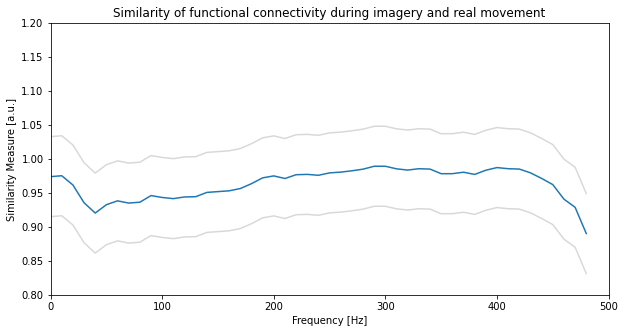

In [42]:
# plt.errorbar(freq_range[:-1], corr, yerr = corr_stds)

fig = plt.figure(figsize = (10,5))
plt.plot(freq_range[:-1], corr)
plt.plot(freq_range[:-1], np.array(corr) + np.array(corr_std), color = "grey", alpha = 0.3)
plt.plot(freq_range[:-1], np.array(corr) - np.array(corr_std), color = "grey", alpha = 0.3)
plt.xlim(0, 500)
plt.ylim(0.8,1.2)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Similarity Measure [a.u.]")
plt.title("Similarity of functional connectivity during imagery and real movement")